# Assignment 1 - CATCH

Sources: \
https://github.com/yxu1168/Reinforcement-Learning-DQN-for-ATARI-s-Pong-Game---TensorFlow-2.0-Keras/blob/master/Reinforcement_Learning_CNN_DQN_for_ATARI%E2%80%99s_Pong_Game.ipynb

https://github.com/PacktPublishing/Hands-on-Reinforcement-Learning-with-PyTorch/blob/master/Section%203/3.5%20DQN%20with%20Pong.ipynb



## Libraries

In [39]:
import random

import matplotlib.pyplot as plt
import numpy as np
from skimage.transform import resize

import tensorflow as tf
from tensorflow import keras

## Catch

In [40]:
class CatchEnv():
    def __init__(self):
        self.size = 21
        self.image = np.zeros((self.size, self.size))
        self.state = []
        self.fps = 4
        self.output_shape = (84, 84)

    def reset_random(self):
        self.image.fill(0)
        self.pos = np.random.randint(2, self.size-2)
        self.vx = np.random.randint(5) - 2
        self.vy = 1
        self.ballx, self.bally = np.random.randint(self.size), 4
        self.image[self.bally, self.ballx] = 1
        self.image[-5, self.pos - 2:self.pos + 3] = np.ones(5)

        return self.step(2)[0]


    def step(self, action):
        def left():
            if self.pos > 3:
                self.pos -= 2
        def right():
            if self.pos < 17:
                self.pos += 2
        def noop():
            pass
        {0: left, 1: right, 2: noop}[action]()


        self.image[self.bally, self.ballx] = 0
        self.ballx += self.vx
        self.bally += self.vy
        if self.ballx > self.size - 1:
            self.ballx -= 2 * (self.ballx - (self.size-1))
            self.vx *= -1
        elif self.ballx < 0:
            self.ballx += 2 * (0 - self.ballx)
            self.vx *= -1
        self.image[self.bally, self.ballx] = 1

        self.image[-5].fill(0)
        self.image[-5, self.pos-2:self.pos+3] = np.ones(5)
    
        terminal = self.bally == self.size - 1 - 4
        reward = int(self.pos - 2 <= self.ballx <= self.pos + 2) if terminal else 0

        [self.state.append(resize(self.image, (84, 84))) for _ in range(self.fps - len(self.state) + 1)]
        self.state = self.state[-self.fps:]

        return np.transpose(self.state, [1, 2, 0]), reward, terminal

    def get_num_actions(self):
        return 3

    def reset(self):
        return self.reset_random()

    def state_shape(self):
        return (self.fps,) + self.output_shape

## Experience Replay Buffer

In [41]:
class ReplayBuffer():
    def __init__(self):
        self.buffer = []
        self.max_size = 1e6
        self.overFlow = 0
    
    def add(self, data):
        if len(self.buffer) == self.max_size:
            self.buffer[int(self.overFlow)] = data
            self.overFlow = (self.overFlow + 1) % self.max_size
        else:
            self.buffer.append(data)

    def sample(self, batch_size):
        indices = np.random.randint(len(self.buffer), size=batch_size)
        states, actions, rewards, states_next, terminals = [], [], [], [], []

        for i in indices:
            s, a, r, sn, t = self.buffer[i]
            states.append(s)
            actions.append(a)
            rewards.append(r)
            states_next.append(sn)
            terminals.append(t)

        return np.array(states), np.array(actions), np.array(rewards), np.array(states_next), np.array(terminals)

## Deep Q Network

In [42]:
input_shape = (84, 84, 4)
num_actions = 3

def DQN_Model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Lambda(lambda x: x / 255.0, input_shape=input_shape),
        tf.keras.layers.Conv2D(32, (8, 8), strides=(4, 4), activation='relu', input_shape=input_shape),
        tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), activation='relu'),
        tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(num_actions)
    ])
    
    return model

## Agent

In [43]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
loss_fn = keras.losses.mean_squared_error

class Agent():
    def __init__(self):
        self.action_size = 3
        self.train_net = DQN_Model()
        self.target_net = DQN_Model()
        
        # hyperparameters
        self.batch_size = 32
        self.epsilon = 0.8
        self.epsilon_end = 0.1
        self.epsilon_decay = 0.001
        self.gamma = 0.95

    # select an action based on epsilon greedy method
    def action(self, state, evaluate):
        if np.random.rand() < self.epsilon and not evaluate:
            return random.randint(0, 2)
        else:
            return np.argmax(self.train_net(state))

    # decay epsilon
    def decay_epsilon(self):
        if self.epsilon > self.epsilon_end:
            self.epsilon -= self.epsilon_decay

    # train the model
    def train(self, replay_buffer):

        # sample from the experience replay buffer
        states, actions, rewards, states_next, terminals = replay_buffer.sample(self.batch_size)

        target_q = rewards + (1 - terminals) * self.gamma * np.max(self.target_net(states_next), axis=1)
        mask = tf.one_hot(actions, self.action_size)

        # GradientTape is a more customizable version of .fit()
        with tf.GradientTape() as tape:
            all_train_q = self.train_net(states)
            train_q = tf.reduce_sum(all_train_q * mask, axis=1, keepdims=True)
            loss = tf.reduce_mean(loss_fn(target_q, train_q))

        gradients = tape.gradient(loss, self.train_net.trainable_variables)
        optimizer.apply_gradients(zip(gradients, self.train_net.trainable_variables))

        return loss

    # update the target network
    def update_target_network(self):
        self.target_net.set_weights(self.train_net.get_weights())

## Main Loop

In [44]:
def run_environment():
    env = CatchEnv()
    agent = Agent()
    replay_buffer = ReplayBuffer()

    # hyperparameters
    episodes = 100
    evaluate = False
    evaluate_point = 10
    update_point = episodes // 10      # when to update the target model

    # trackers
    reward_tracker = []
    loss_tracker = []

    for episode in range(episodes):

        state = env.reset()
        terminal = False
        
        while not terminal:
            
            # agent takes an action
            action = agent.action(np.reshape(state, (1, 84, 84, 4)), evaluate)

            # generate the next frame based on the agent action
            state_next, reward, terminal = env.step(action)

            # add experience to replay buffer
            replay_buffer.add((state, action, reward, state_next, terminal))

            # train the agent
            if not evaluate:
                loss = agent.train(replay_buffer)
                loss_tracker.append(loss.numpy())

            # update the current state
            state = state_next

        # decay epsilon
        agent.decay_epsilon()

        # update the target network
        if not episode % update_point and episode != 0:
            agent.update_target_network()

        # toggle agent evaluation
        if not episode % evaluate_point and episode != 0:
            evaluate = not evaluate

        # stats
        reward_tracker.append(reward)
        print("EPISODE: {} --- Rewards: {} --- Ratio: {} --- Evaluate: {}".format(episode, sum(reward_tracker), round(sum(reward_tracker)/(episode + 1), 2), evaluate))

    return np.array(reward_tracker), np.array(loss_tracker)

# Run

In [45]:
rewards, loss = run_environment()

EPISODE: 0 --- Rewards: 1 --- Ratio: 1.0 --- Evaluate: False
EPISODE: 1 --- Rewards: 1 --- Ratio: 0.5 --- Evaluate: False
EPISODE: 2 --- Rewards: 1 --- Ratio: 0.33 --- Evaluate: False
EPISODE: 3 --- Rewards: 2 --- Ratio: 0.5 --- Evaluate: False
EPISODE: 4 --- Rewards: 2 --- Ratio: 0.4 --- Evaluate: False
EPISODE: 5 --- Rewards: 2 --- Ratio: 0.33 --- Evaluate: False
EPISODE: 6 --- Rewards: 2 --- Ratio: 0.29 --- Evaluate: False
EPISODE: 7 --- Rewards: 2 --- Ratio: 0.25 --- Evaluate: False
EPISODE: 8 --- Rewards: 3 --- Ratio: 0.33 --- Evaluate: False
EPISODE: 9 --- Rewards: 3 --- Ratio: 0.3 --- Evaluate: False
EPISODE: 10 --- Rewards: 3 --- Ratio: 0.27 --- Evaluate: True
EPISODE: 11 --- Rewards: 3 --- Ratio: 0.25 --- Evaluate: True
EPISODE: 12 --- Rewards: 3 --- Ratio: 0.23 --- Evaluate: True
EPISODE: 13 --- Rewards: 3 --- Ratio: 0.21 --- Evaluate: True
EPISODE: 14 --- Rewards: 3 --- Ratio: 0.2 --- Evaluate: True
EPISODE: 15 --- Rewards: 4 --- Ratio: 0.25 --- Evaluate: True
EPISODE: 16 --

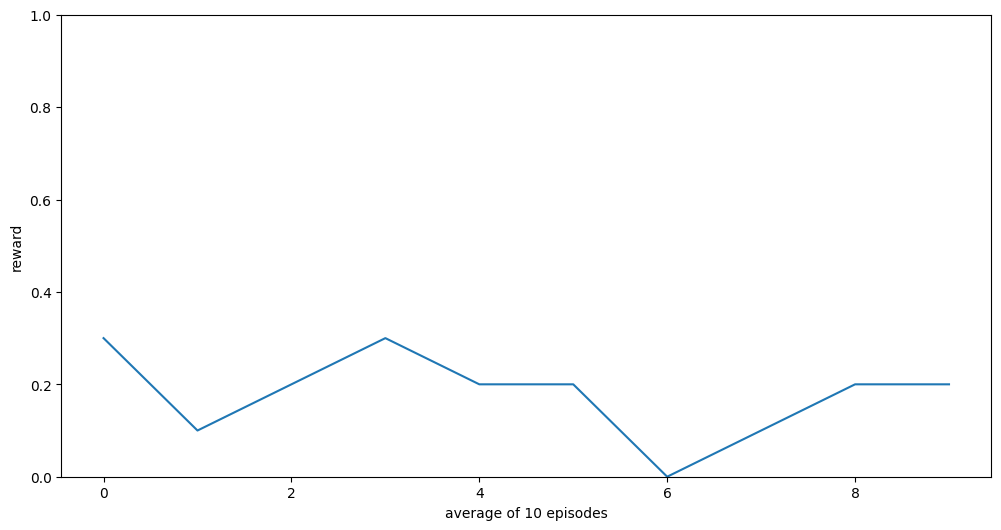

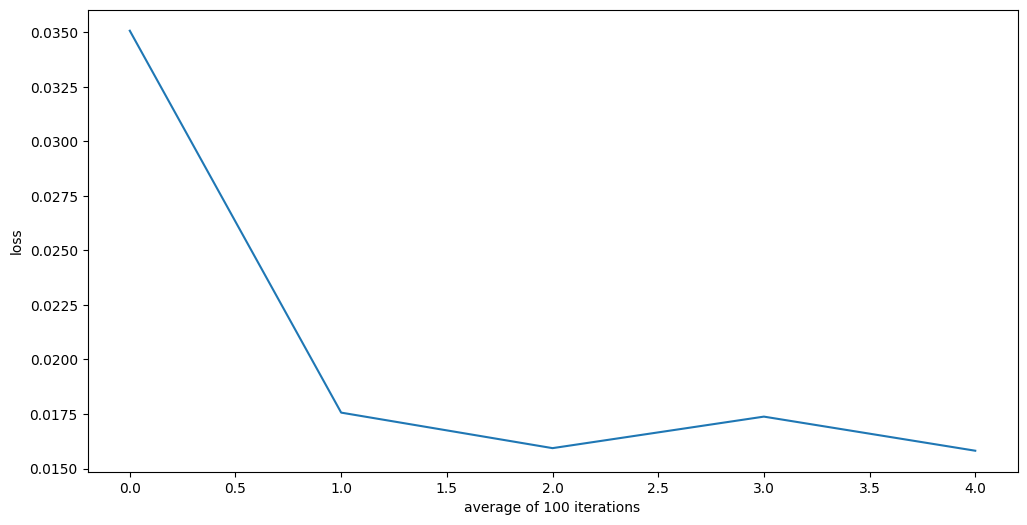

In [46]:
# average reward across 10 episodes
num_episodes = 10
num_samples = rewards.size
num_batches = rewards.size // 10
reward_reshaped = rewards[:num_batches*num_episodes].reshape(num_batches, num_episodes)
average_reward = np.mean(reward_reshaped, axis=1)
plt.figure(figsize=(12,6))
plt.plot(average_reward)
plt.xlabel(f"average of {num_episodes} episodes")
plt.ylabel("reward")
plt.ylim(0, 1)
plt.show()


# average loss across 100 iterations
num_iterations = 100
num_samples = loss.size
num_batches = num_samples // num_iterations
loss_episode_reshaped = loss[:num_batches*num_iterations].reshape(num_batches, num_iterations)
average_loss = np.mean(loss_episode_reshaped, axis=1)
plt.figure(figsize=(12,6))
plt.plot(average_loss)
plt.xlabel(f"average of {num_iterations} iterations")
plt.ylabel("loss")
plt.show()
